<a href="https://colab.research.google.com/github/gloria256/EXPERIMENTOS/blob/master/multiplic-plana-250-64-GoogleNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CLASIFICADOR BINARIO USANDO LA RED: GOOGLENET**







## **1. Librerías necesarias y descarga de la función para graficar la curva ROC.**


In [1]:
#IMPORTACION DE LIBRERIAS NECESARIAS
import pandas as pd
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
from keras.applications.resnet import preprocess_input, decode_predictions
import sklearn

# ACCESO A GOOGLE DRIVE
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#ARCHIVO DE FUNCIONES
file_id = '1QTJIzZb4xL9_it6AF4qpz6KJGIpprIVD' 
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('funciones_people.py') 
from funciones_people import roc_multiclass, roc_auc_mc


Using TensorFlow backend.


## **4. Descargar imágenes de CIFAR-10**

consta de 60000 imágenes en color de 32x32 en 10 clases, con 6000 imágenes por clase. Hay 50000 imágenes de entrenamiento y 10000 imágenes de prueba.

El conjunto de datos se divide en cinco lotes de entrenamiento y un lote de prueba, cada uno con 10000 imágenes. El lote de prueba contiene exactamente 1000 imágenes seleccionadas al azar de cada clase. 

$avión\hspace{1em}automóvil\hspace{1em}pájaro\hspace{1em}gato    
ciervo\hspace{1em}perro\hspace{1em}rana\hspace{1em}caballo\hspace{1em}
Embarcacion\hspace{1em}camión$

#### **A:** Funciones, para seleccionar solo las clases: Gato y perro

In [0]:
def obtener_solo_imagenes_Etiqueta(imagen,etiqueta,num_etiqueta):
  Gatos_label=np.where(etiqueta== num_etiqueta)
  A=np.zeros([len(Gatos_label[0]),32,32,3],dtype=np.uint8)
  for c,i in enumerate(Gatos_label[0]): 
    A[c]=imagen[i]
  return A

def cambiar_scala_229x229(imagen):
  matriz_imagen1=np.zeros([len(imagen),229,229,3],dtype=np.uint8)
  for i in range(len(imagen)):
    img=imagen[i]
    scale_percent = 715.625 # percent of original size
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    matriz_imagen1[i]=resized
  return matriz_imagen1

#### **B:** Descargar de keras datasets CIFAR10 y seleccionar las imagenes de las clases gato y perro del conjunto de **Train** y **Test**




In [3]:
#IMPORTAMOS EL CONJUNTO DE DATOS DE CIFAR10 DONE: Xdata[0][0]-->Train   Xdata[1][0]-->Test  Xdata[0][1]-->Ytrain  Xdata[1][1]-->Ytest
import tensorflow as tf
from keras.datasets import cifar10

Xdata = tf.keras.datasets.cifar10.load_data()
Xdata[1][0].shape


170500096/170498071 [==============================] - 2s 0us/step


(10000, 32, 32, 3)

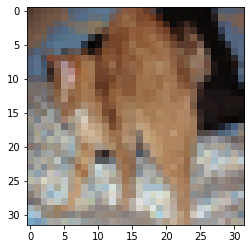

In [4]:
#OBTENEMOS SOLO LAS IMAGENES DE GATO=3 y perro=5 DE TEST DE CIFAR10, SON 1000 IMAGENES DE GATO y 1000 IMAGENES DE PERRO
gato_test = obtener_solo_imagenes_Etiqueta(Xdata[1][0],Xdata[1][1],num_etiqueta=3)
perro_test = obtener_solo_imagenes_Etiqueta(Xdata[1][0],Xdata[1][1],num_etiqueta=5)

#OBTENEMOS SOLO LAS IMAGENES DE GATO=3 y perro=5 DE TRAIN DE CIFAR10, SON 5000 IMAGENES DE GATO y 5000 IMAGENES DE PERRO
gato_train = obtener_solo_imagenes_Etiqueta(Xdata[0][0],Xdata[0][1],num_etiqueta=3)
perro_train = obtener_solo_imagenes_Etiqueta(Xdata[0][0],Xdata[0][1],num_etiqueta=5)

plt.imshow(gato_test[999])
plt.show()

## **5. Agrupar conjunto de datos, en uno solo (X)**

Gato_test, Conjunto de satos de 1000 imágenes tomadas de CIFAR10 - TEST
Gato_train, Conjunto de satos de 5000 imágenes tomadas de CIFAR10 - TRAIN

perro_test, Conjunto de satos de 1000 imágenes tomadas de CIFAR10 - TEST
perro_train, Conjunto de satos de 5000 imágenes tomadas de CIFAR10 - TRAIN


> $X= Cifar10_{gato} + Cifar10_{perro}$


####**A:** Unir etiquetas y matrices de cada conjunto para fromar **X** de 2000 imágenes

In [5]:
#UNIR LAS IMAGENES EN UN SOLO CONJUNTO
#X = np.concatenate((gato_test[0:500], gato_train[0:500], perro_test[0:500], perro_train[0:500]), axis=0)
#X_label=np.concatenate(([1]*500, [1]*500, [0]*500, [0]*500), axis=0)
#UNIR ETIQUETAS EN UN SOLO CONJUNTO 
# 1-->GATO   0-->PERRO

Xtrain = np.concatenate((gato_train[0:800], perro_train[0:800]), axis=0)
Xtrain_label=np.concatenate(([1]*800,[0]*800), axis=0)
Xtest  = np.concatenate((gato_test[0:200], perro_test[0:200]), axis=0)
Xtest_label=np.concatenate(([1]*200,[0]*200), axis=0)

print(len(Xtrain),len(Xtrain_label),'  y  ',len(Xtest),len(Xtest_label))

1600 1600   y   400 400


#### **B:** Cambiar tamaño de 32x32x3, a scala de: 229x229x3 (**Ver función:** cambiar_scala_229x229(X))




In [6]:
import cv2
Xtrain=cambiar_scala_229x229(Xtrain)
Xtest=cambiar_scala_229x229(Xtest)
print(Xtrain.shape,'  ',Xtest.shape)

(1600, 229, 229, 3)    (400, 229, 229, 3)


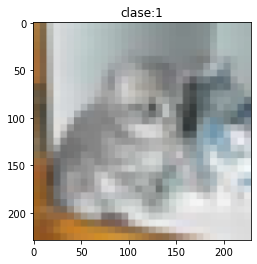

In [7]:
plt.imshow(Xtrain[5])
plt.title('clase:%s'%Xtrain_label[5])
plt.show()

####**C:** Pasar X, a un pandas, en este caso por cuestiones de espacio en memoria, solo se cojen: X[i][0][0][0:3] y se agrega para cada imagen al pandas X_PD con sus respectivas etiquetas X_label.




In [0]:
#ARMAR PANDAS CON SOLO 5 DATOS DE CADA UNA DE LAS 12000 IMAGENES PARA PODER PARTICIONAR EL CONJUNTO Y PODER SACAR YTRAIN Y YTEST
Xtrain_PD=np.zeros([len(Xtrain),3])
Xtest_PD=np.zeros([len(Xtest),3])

for i in range(len(Xtrain)):
  Xtrain_PD[i]=Xtrain[i][0][0][0:3]

for i in range(len(Xtest)):
  Xtest_PD[i]=Xtest[i][0][0][0:3]


In [0]:
#ARMAR PANDAS DE TODAS LAS IMAGENNES, SE BARAJAN Y SE DEJAN LOS INDICES SIN REINICIAR, PARA LUEGO ENCONTRAR LA IMAGEN QUE LE PERTENECE A CADA ETIQUETA.
Xtrain_PD=pd.DataFrame(Xtrain_PD)
Xtrain_PD["label"]=Xtrain_label    
Xtrain_PD = Xtrain_PD.sample(frac=1)#.reset_index(drop=True) #frac=1significa devolver todas las filas (en orden aleatorio).

Xtest_PD=pd.DataFrame(Xtest_PD)
Xtest_PD["label"]=Xtest_label    
Xtest_PD = Xtest_PD.sample(frac=1)

####**C:** Se particiona el conjuto de X_PD en Xtrain y Xtest, con 80%, 20% respectivamente y se sacan los Ytrain, Ytest por aparte.

In [10]:
#PARTICIONAR EL CONJUNTO DE XDATA EN XTRAIN Y XTEST
#from sklearn.model_selection import train_test_split
#Xtrain, Xtest = train_test_split(X_PD,test_size=0.2)

col_sal="label"
Ytrain = Xtrain_PD[col_sal]
Xtrain_PD.drop(columns=col_sal,inplace=True)
Ytest = Xtest_PD[col_sal]
Xtest_PD.drop(columns=col_sal,inplace=True)

print(len(Ytrain),len(Ytest))

1600 400


####**D:** Del pandas **X_PD** creado, se saca Ytrain, luego aquí,se sacan sus indices y se relacionan con la matrix de datos unidos **X** para armar el array **XTRAIN** que es el que va a la entrada de la red neuronal VGG-16.

In [11]:
#SE ARMA EL CONJUNTO XTRAIN FINAL, A PARTIR DE LOS INDICES DE LAS ETIQUETAS.

def relacion_indices_etiquetas_con_XTRAIN(X,Y):
  A=np.zeros([len(Y),229,229,3],dtype=np.uint8)
  B=[]
  for c,i in enumerate(Y.index):
    A[c]=X[i]
    B.append(Y[i])
  return A,np.array(B)


XTRAIN,YTRAIN = relacion_indices_etiquetas_con_XTRAIN(Xtrain,Ytrain)
XTEST,YTEST = relacion_indices_etiquetas_con_XTRAIN(Xtest,Ytest)
print('xtrain: ',XTRAIN.shape,YTRAIN.shape,'  xtest: ',XTEST.shape,YTEST.shape)

#c = np.all(np.array(YTRAIN) == np.array(Ytrain))
#Ytrain.index

xtrain:  (1600, 229, 229, 3) (1600,)   xtest:  (400, 229, 229, 3) (400,)


In [12]:
#LAS PASAMOS A TENSOR, NO HAYNECESIDAD DE QUE YTRAIN SEA UN TENSOR.
XTRAIN=tf.constant(XTRAIN)
YTRAIN=tf.constant(YTRAIN)

XTEST=tf.constant(XTEST)
YTEST=tf.constant(YTEST)

print(type(XTRAIN))

<class 'tensorflow.python.framework.ops.EagerTensor'>


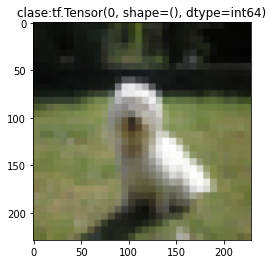

In [13]:
plt.imshow(XTRAIN[5])
plt.title('clase:%s'%YTRAIN[5])
plt.show()


##**6. Importar el modelo de la GoogleNet y configurar el último bloque.**


### Dejar la ultima capa y agregar la capa densa de salida, para que tenga 1 salida.  

In [15]:
import tensorflow as tf

model = tf.keras.applications.inception_v3.InceptionV3(weights='imagenet')#,include_top=False)
model= tf.keras.models.Model(inputs=model.input, outputs=model.layers[-2].output)#-2, quita solo la ultima capa

predictions = tf.keras.layers.Dense(1000, activation="relu", name='predictions')(model.output)
predictions1 = tf.keras.layers.Dense(1000, activation="relu", name='predictions1')(predictions)
#X =  tf.keras.layers.Dropout(0.2)
X=tf.keras.layers.dot([predictions1, predictions], axes=1, normalize=True)#PROBAR CON TRUE
output = tf.keras.layers.Dense(1, activation="sigmoid", name='salida')(X)
model = tf.keras.models.Model(inputs=model.input, outputs=output)

model.summary()
#tf.keras.utils.plot_model(model_GoogleNet,show_shapes=True, show_layer_names=True)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 149, 149, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 149, 149, 32) 0           batch_normalization_94[0][0]     
____________________________________________________________________________________________

In [0]:
#SE CONGELAN LOS PESOS DE TODAS LAS CAPAS MENOS DE LAS cuatro ULTIMAS CAPAS
for layer in model.layers[:-4]:
  layer.trainable=False

In [17]:
#SE VERIFICA QUE LAS CUATRO ULTIMAS CAPAS ESTE EN TRUE Y LAS DEMÁS EN FALSE
for layer in model.layers:
  layer, layer.trainable
  print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f398cdae1d0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f398cdae828> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f398cdae5f8> False
<tensorflow.python.keras.layers.core.Activation object at 0x7f398cdaedd8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f398cd4ec18> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f398cd56470> False
<tensorflow.python.keras.layers.core.Activation object at 0x7f398cd56ba8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f398cd56be0> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f398cd03400> False
<tensorflow.python.keras.layers.core.Activation object at 0x7f398cd03f60> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f398cd03ac8> False
<tensorflow.python.keras.layers.c

##**6. Definir el optimizador para la funcion de costo, así como la funcion de pérdida y las metricas de evaluación del odelo a través de la compilacion del modelo.**

Loss $\hspace{1em} \rightarrow \hspace{1em}$ $-ylog(x)\hat{y} + (1-y)log(1-\hat{y}) $ 


In [0]:
#DEFINIR OPTIMIZADOR, FUNCIONES DE PERIDA Y METRICAS
#optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)#, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
#loss='mean_squared_logariic_errorthm'
#loss='mean_squared_error'
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['mse','mae','accuracy','Recall','Precision'])#,

##**7. Entrenar el modelo con XTRAIN como un array de 4 dimensiones.**

---




In [19]:
print(len(XTRAIN),len(YTRAIN))


1600 1600


In [20]:
#ENTRENAR EL MODELO CREADO
history=model.fit(XTRAIN,YTRAIN,epochs=250,batch_size=64)               

Epoch 1/250
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
25/25 [==============================] - 2s 75ms/step - loss: 0.6923 - mse: 0.2496 - mae: 0.4989 - accuracy: 0.5188 - recall: 0.2237 - precision: 0.5457
Epoch 2/250
25/25 [==============================] - 2s 75ms/step - loss: 0.6914 - mse: 0.2491 - mae: 0.4989 - accuracy: 0.5119 - recall: 0.0450 - precision: 0.6792
Epoch 3/250
25/25 [==============================] - 2s 75ms/step - loss: 0.6895 - mse: 0.2482 - mae: 0.4972 - accuracy: 0.5319 - recall: 0.1200 - precision: 0.6809
Epoch 4/250
25/25 [==============================] - 2s 74ms/step - loss: 0.6860 - mse: 0.2464 - mae: 0.4954 - accuracy: 0.5656 - recall: 0.2887 - precision: 0.6471
Epoch 5/250
25/25 [==============================] - 2s 74ms/step - loss: 0.6797 - mse: 0.2433 - mae: 0.4919 - accuracy: 0.5994 - recall: 0.4512 - precision: 0.6412
Epoch 6/250
25/25 [==============================] - 2s 74ms/step - loss: 0.6775 - mse: 0.2422

##**8. Generar gráfica de: loss(pérdida) y accuracy(acierto) en cada época realizada.**

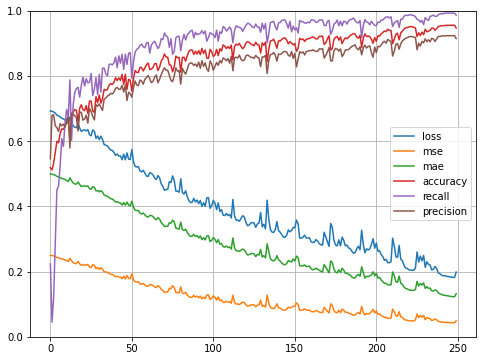

In [21]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 6))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

##**9. Predecir con el modelo, la clasificación de cada imagen del conjunto de Test**

In [22]:
#SE EVALÚA EL MODELO

Valores=(model.predict(XTEST))
#Valores

In [23]:
#Valores_label=np.argmax(Valores, axis=1)
#Valores_label
Valores_label=np.around(Valores)
Valores_label.shape

(400, 1)

##**10. Sacar métricas de evaluación, para mirar el rendimiento del modelo.**

> **A. Matriz de confusión simple.**

In [24]:
from sklearn.metrics import confusion_matrix, accuracy_score

#YTEST=YTEST.reshape(len(Ytest),1)

acc = accuracy_score(YTEST,Valores_label)
print('acierto: ',acc)
cm=confusion_matrix(YTEST,Valores_label)
cm

acierto:  0.59


array([[101,  99],
       [ 65, 135]])


>**B. Matriz de confusión, con porcentjes de acierto.**

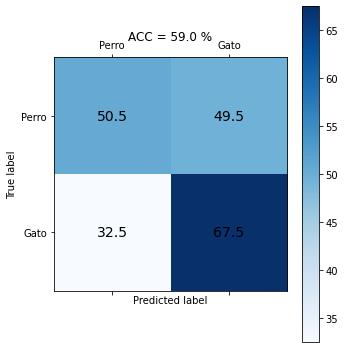

In [25]:
from sklearn.utils.multiclass import unique_labels


def plot_confusion_matrix(matrix,Ytest,Valores_label,acc,Valores2):
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111)
    cmap=plt.cm.Blues
    matrix = 100*matrix.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cax = ax.matshow(matrix, interpolation='nearest', cmap=cmap)
    fig.colorbar(cax)
    classes = unique_labels(Ytest,Valores_label)
    classes1= Valores2
    ax.set(xticks=np.arange(matrix.shape[1]),
           yticks=np.arange(matrix.shape[0]),
           xticklabels=classes1, yticklabels=classes1,
           title='ACC = %.1f %%' % (100*acc),
           ylabel='True label',
           xlabel='Predicted label')
    fmt = '.1f'
    thresh = matrix.max() / 2.
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            ax.text(j, i, format(matrix[i, j], fmt),
                    ha="center", va="center",
                    color="black",fontsize=14)
    fig.tight_layout()

#Valores_label_texto=convertir_salida_texto(Valores_label)
plot_confusion_matrix(cm,YTEST,Valores_label,acc,Valores2=["Perro","Gato"])




> **C. Reporte de algunas métricas: Precisión, recall, F1 y Support, para el umbral de clasificación 0,5(por defecto usado por keras).**


In [26]:
from sklearn.metrics import classification_report

target_names = ['Perro', 'Gato']
cr=classification_report(YTEST, Valores_label,labels=range(len(target_names)),target_names=target_names)
print(cr) 

              precision    recall  f1-score   support

       Perro       0.61      0.51      0.55       200
        Gato       0.58      0.68      0.62       200

    accuracy                           0.59       400
   macro avg       0.59      0.59      0.59       400
weighted avg       0.59      0.59      0.59       400



>**D. Curva ROC, para cada clase, variando los umbrales de decisión(Thresold) o, en este caso con la probabilidad de que pertenezca a una de las salidas.**

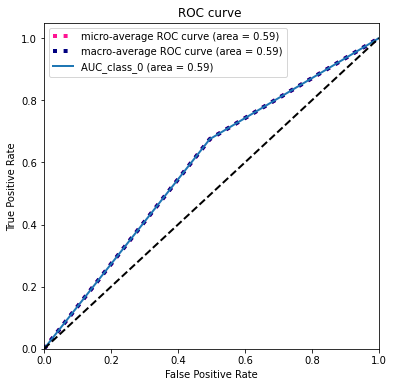

In [27]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc



Ytest_Bin= label_binarize(YTEST, classes=[0,1])
Valores_Bin= label_binarize(Valores_label, classes=[0,1])
roc_auc, fpr, tpr, n_classes = roc_multiclass(Ytest_Bin,Valores_Bin,colum=1)
roc_auc_mc(roc_auc,fpr,tpr,n_classes,'ROC curve ')



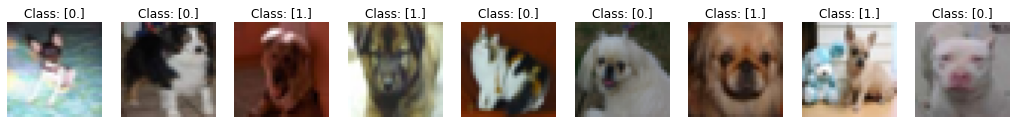

In [28]:
#GRAFICAR LAS PRIMERAS 10 CLASES
tam=10
index=0
plt.figure(figsize=(tam*2, 12))
for i in range(1,tam):
  index += 1
  plt.subplot((tam//10), 10, index)
  plt.imshow(XTEST[i-1])
  plt.title("Class: {}".format(Valores_label[i-1]))
  plt.axis("off")
plt.show() 